# Preparing and converting data

In [1]:
##tentative implémentation code Thibault

In [2]:
from collections import defaultdict
from collections import namedtuple
from collections import Counter
from tqdm import tqdm

from thibaultScript import (
    import_known_tokens,
    compile_scores#,
#    convert_raw#,
#    vjui
)

from pandas import DataFrame, Series
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from numpy import mean, median

In [3]:
def convert_raw(gold, task_list=[], 
                form_fn=lambda x: x, 
                lemma_fn=lambda x: x, 
                pos_fn=lambda x: x,
                pos_key = "POS",
                remove_disambiguation = False
               ):
    """ Converts input data into Gold data.
        The main goal here is to treat cases like apostrophes, so that two tokens _l/'_
        became one _l'_
        And handle fucking roman numerals
    """
    temp_out = []
    pass_next = False
    
    for sentence in tqdm(gold):
        temp_sentence = []
        no_sentence_append = False
        # Handle roman numerals
        for idx,token in enumerate(sentence):
            if pass_next:
                pass_next = False
                continue
            
            new_token = {task: "_" for task in task_list}
            new_token.update({
                "form": form_fn(token["form"]),
                "lemma": lemma_fn(token["lemma"]),
                "POS": pos_fn(token[pos_key]),
            })
            # No disambiguation at the lemmatizer lever
            if remove_disambiguation and new_token["lemma"][-1].isnumeric():
                new_token["lemma"] = new_token["lemma"][:-1]
                
            if new_token["form"] in {"’", "'"} and temp_sentence:
                temp_sentence[-1]["form"] += "'"
                
            # roman numerals
            # not useful now, because we do it when loading sentences
            # but might serve someday
            elif (
                # is there a phrase before, and does it ends with .
                temp_out and temp_out[-1] and temp_out[-1][-1]["form"] == "."
                # and are we at the start of a sentence, and not the end
                and idx == 0 and idx < (len(sentence) - 1) 
                # and next token a .
                and sentence[idx+1]["form"] == '.'
                and token[pos_key].endswith("car")
            ):
                new_token["form"] = "."+new_token["form"]+"."
                temp_out[-1][-1] = new_token
                # and now some acrobatics
                pass_next = True
                temp_sentence = temp_out[-1]
                no_sentence_append = True
                
            else:
                temp_sentence.append(new_token)
        if not no_sentence_append:
            temp_out.append(temp_sentence)
    return temp_out

In [4]:
KNOWN_TOKENS, KNOWN_LEMMAS = import_known_tokens()

In [5]:
#KNOWN_TOKENS

In [6]:
#TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")
TASKS = "lemma,POS".split(",")

In [7]:
Texts = []
GOLD = defaultdict(list)

nb_tokens = 0

def filter_gold(data):
    return [lst for lst in data if lst]


import regex

punkts = regex.compile(r"\W+")
greek = regex.compile(r"\p{Greek}+")

def keep_tokens(token):
    if greek.match(token):
        print(token)
        return False
    return True

key = None
with open("nca-sample-naomicorr.tsv") as f:
    header = []
    current_text = None
    for lineno, line in enumerate(f):
        line = line.strip().split("\t")
        if lineno == 0:
            header = line
            continue
        
        line = dict(zip(header, line))
        
        if line["form"].startswith("[REF:"):
            if key:
                GOLD[key] = filter_gold(GOLD[key])
                
            key = line["form"][5:-1]
            
            #Texts.append((line["form"], nb_tokens, len(GOLD)))
            GOLD[key].append([])
            continue
        
        if line["POS"] == "PONfrt":
            if GOLD[key][-1] != []:
                # And now for some more Roman Numerals
                if GOLD[key][-1][-1]["POS"].endswith("car") and line["form"] == '.':
                    GOLD[key][-1].append(line)
                else:
                    GOLD[key][-1].append(line)
                    GOLD[key] = filter_gold(GOLD[key])
                    GOLD[key].append([])
        elif keep_tokens(line["form"]):
            GOLD[key][-1].append(line)
            nb_tokens += 1
            

if GOLD[key][-1] == []:
    GOLD[key] = GOLD[key][:-1]
print(f"{len(GOLD)} texts found")
print(f"{sum([len(t) for t in GOLD.values()])} sentences found")
# Compute texts Lengths
#for cur, nxt in zip(Texts, Texts[1:] + [None]):
#    if nxt is None:
#        TextsLengths[cur[0]] = nb_tokens - cur[1]
#    else:
#        TextsLengths[cur[0]] = nxt[1] - cur[1]
# Update titles
#TextsTitles = {
#    urn: f"{title} ({TextsLengths.get(urn, '?')} mots)"
#    for urn, title in TextsTitles.items()
#}
#print(TextsTitles)

275 texts found
1616 sentences found


In [8]:
TextsTitles = list(GOLD.keys())
TextsTitles[-5:]

['YvainL;PercL_1311',
 'YvainL;PercL_1877',
 'CharroiSch_B2*_739',
 'VillehF_658',
 'AlexArsL_438']

# Scores for full corpus

## Tagging and getting global scores

In [9]:
# Lemmatise and regroup everyting in one single value to make it work
PLATINUM = [
    sentence
    for text in GOLD
    for sentence in convert_raw(GOLD[text], form_fn = lambda x: x.replace('§', ''))
]

100%|██████████████████████████████████████████| 7/7 [00:00<00:00, 11734.66it/s]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9066.81it/s]


In [10]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in PLATINUM
]
# Vérif romains
#[t for s in TOKENS for t in s if t[0] == '.']
# vérif tokens
TOKENS[0]

['Longue',
 'atente',
 'vous',
 'poroit',
 'nuire',
 ',',
 'ce',
 "m'",
 'est',
 'vis',
 ':',
 'si',
 'lo',
 'que',
 'vous',
 'soiiés',
 'amis',
 'en',
 'un',
 'haut',
 'liu',
 ',',
 'se',
 'vous',
 'veés',
 'que',
 'vous',
 'i',
 'soiiés',
 'bien',
 'amés',
 '.']

In [11]:
TASKS

['lemma', 'POS']

In [12]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 64


OUTPUT = []
TEST_NEW = True

#tagger = Tagger(device="cuda", batch_size=100, lower=False, tokenize=False)
tagger = Tagger(device=DEVICE, batch_size=BATCH_SIZE, lower=False, tokenize=False)
if TEST_NEW:
    for task in TASKS:
        tagger.add_model(f"modeles/{task}.tar", task)
#else:
#    tagger.add_model("../../../latin-lasla-models/lasla-plus.tar", *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])


fatal: ni ceci ni aucun de ses répertoires parents n'est un dépôt git : .git
It seems like you downloaded `pie` instead of git-cloning it or installing it with pip.
We won't be able to check compatibility between pretrained models and `pie` version.

25it [01:46,  4.26s/it]


In [13]:
#OUTPUT[0]

In [14]:
from collections import defaultdict, Counter


RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT, PLATINUM, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS)

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate
from IPython.display import HTML, display

data = [["Task", "Accuracy"]]#, "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.2f}".format(accuracy_score(truth, pred)*100)#,
        #"{0:.2f}".format(accuracy_score(pred_limited, truth_limited)*100)
    ])
    
df = DataFrame([x[1:] for x in data[1:]], columns=data[0][1:], index=[x[0] for x in data[1:]]).sort_index()
display(HTML(df.to_html()))
#print(df.to_latex())

## Lemma scores per POS category

In [16]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(list)
_, Scores_all2, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)

NBTOKENS = 0
NBERRORS = 0

for (lemma_pred, lemma_truth,  pos_truth) in zip(
   Scores_all2["lemma"][0],
   Scores_all2["lemma"][1],
   Scores_all2["POS"][1]
):
    Stats_Per_Pos[pos_truth].append(int(lemma_pred == lemma_truth))
    NBTOKENS +=1
    NBERRORS += int(lemma_pred != lemma_truth)


In [17]:
#LIMIT_TO_POS = {"VERcjg", "VERinf", "VERppe", "VERppa", "NOMcom", "ADJqua"}#LISTE À CONFIRMER


def compute_accuracy(trues, corpus_size, corpus_accuracy) -> int:
    return ((len(trues) - sum(trues)) / corpus_size) / corpus_accuracy

PosLemmaDetails = DataFrame([
    {
        "POS": pos, 
        "Accuracy": sum(equals) / len(equals), 
        "Error contrib %": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS),
        "Support": len(equals),
        "Support relatif": len(equals) / NBTOKENS,
        "Diff contrib support": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS) - len(equals) / NBTOKENS
    }
    for pos, equals in Stats_Per_Pos.items()
    #if pos in LIMIT_TO_POS
])

#Impact means: contribution to total error (in %)
# TODO: réfléchir meilleur mesure
PosLemmaDetails.sort_values("Diff contrib support", ascending=False)

POS  Accuracy  Error contrib %  Support  Support relatif  \
26         NOMpro  0.075740         0.259641      845         0.024963   
1          NOMcom  0.836044         0.251330     4611         0.136219   
18         PROrel  0.791317         0.049535      714         0.021093   
0          ADJqua  0.847943         0.056516     1118         0.033028   
12         VERppe  0.871926         0.041556      976         0.028833   
20         DETcar  0.734694         0.008644       98         0.002895   
39         VERppa  0.735294         0.005984       68         0.002009   
30         ADJcar  0.578947         0.002660       19         0.000561   
22         PROind  0.888060         0.009973      268         0.007917   
47            ETR  0.000000         0.001662        5         0.000148   
42            INJ  0.700000         0.001995       20         0.000591   
40         PROcar  0.800000         0.002327       35         0.001034   
25         PROord  0.666667         0.001662       15         0.000443   
35         PROint  0.791667         0.001662       24         0.000709   
29            OUT  0.000000         0.000665        2         0.000059   
33         ADJord  0.869565         0.000997       23         0.000679   
49  PROrel.PROper  0.000000         0.000332        1         0.000030   
48            ABR  0.000000         0.000332        1         0.000030   
38         ADJpos  0.888889         0.000997       27         0.000798   
46         PROpos  0.916667         0.000332       12         0.000355   
50            RED  1.000000         0.000000        1         0.000030   
31         ADJint  1.000000         0.000000        1         0.000030   
32         DETint  1.000000         0.000000        3         0.000089   
45  PROper.PROper  1.000000         0.000000        4         0.000118   
43         DETrel  1.000000         0.000000        7         0.000207   
41  ADVgen.PROper  1.000000         0.000000        8         0.000236   
37         PROimp  0.935484         0.000665       31         0.000916   
44         ADVint  1.000000         0.000000       10         0.000295   
36         ADVsub  0.967742         0.000332       31         0.000916   
28  ADVneg.PROper  1.000000         0.000000       22         0.000650   
34         ADJind  0.948276         0.000997       58         0.001713   
27         DETdem  0.936709         0.003324      158         0.004668   
4          VERinf  0.921250         0.020944      800         0.023634   
6          PROdem  0.938547         0.007314      358         0.010576   
10         DETndf  0.994413         0.000332      179         0.005288   
14         PONpdr  0.990991         0.000665      222         0.006558   
24     PRE.DETdef  0.968571         0.003657      350         0.010340   
15         PONpga  1.000000         0.000000      227         0.006706   
11         PROadv  0.961538         0.005319      416         0.012290   
8          CONsub  0.932859         0.021941      983         0.029040   
21         DETind  1.000000         0.000000      269         0.007947   
16         DETpos  0.957983         0.009973      714         0.021093   
17         ADVneg  0.986859         0.003324      761         0.022482   
7          ADVgen  0.937877         0.044548     2157         0.063722   
3          VERcjg  0.924913         0.115027     4608         0.136130   
23         DETdef  0.983062         0.008644     1535         0.045347   
13         PONfrt  0.999298         0.000332     1424         0.042068   
19         CONcoo  0.988095         0.006981     1764         0.052112   
2          PROper  0.967098         0.027926     2553         0.075421   
9             PRE  0.980361         0.016622     2546         0.075214   
5          PONfbl  0.997471         0.002327     2768         0.081773   

    Diff contrib support  
26              0.234678  
1               0.115111  
18              0.028442  
0               0.023488  
12              0.012723  
20 

## POS scores per POS category

In [18]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(list)
_, Scores_all2, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)

NBTOKENS = 0
NBERRORS = 0

for (pos_pred, pos_truth,  pos_truth) in zip(
   Scores_all2["POS"][0],
   Scores_all2["POS"][1],
   Scores_all2["POS"][1]
):
    Stats_Per_Pos[pos_truth].append(int(pos_pred == pos_truth))
    NBTOKENS +=1
    NBERRORS += int(pos_pred != pos_truth)


PosPosDetails = DataFrame([
    {
        "POS": pos, 
        "Accuracy": sum(equals) / len(equals), 
        "Error contrib %": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS),
        "Support": len(equals),
        "Support relatif": len(equals) / NBTOKENS,
        "Diff contrib support": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS) - len(equals) / NBTOKENS
    }
    for pos, equals in Stats_Per_Pos.items()
    #if pos in LIMIT_TO_POS
])

#Impact means: contribution to total error (in %)
# TODO: réfléchir meilleur mesure
PosPosDetails.sort_values("Diff contrib support", ascending=False)
    

POS  Accuracy  Error contrib %  Support  Support relatif  \
0          ADJqua  0.805903         0.121910     1118         0.033028   
18         PROrel  0.862745         0.055056      714         0.021093   
1          NOMcom  0.936456         0.164607     4611         0.136219   
22         PROind  0.764925         0.035393      268         0.007917   
12         VERppe  0.902664         0.053371      976         0.028833   
7          ADVgen  0.930459         0.084270     2157         0.063722   
26         NOMpro  0.907692         0.043820      845         0.024963   
20         DETcar  0.663265         0.018539       98         0.002895   
37         PROimp  0.387097         0.010674       31         0.000916   
34         ADJind  0.689655         0.010112       58         0.001713   
40         PROcar  0.542857         0.008989       35         0.001034   
38         ADJpos  0.518519         0.007303       27         0.000798   
39         VERppa  0.779412         0.008427       68         0.002009   
36         ADVsub  0.645161         0.006180       31         0.000916   
25         PROord  0.333333         0.005618       15         0.000443   
21         DETind  0.914498         0.012921      269         0.007947   
30         ADJcar  0.526316         0.005056       19         0.000561   
35         PROint  0.750000         0.003371       24         0.000709   
47            ETR  0.000000         0.002809        5         0.000148   
43         DETrel  0.428571         0.002247        7         0.000207   
46         PROpos  0.666667         0.002247       12         0.000355   
8          CONsub  0.944049         0.030899      983         0.029040   
33         ADJord  0.826087         0.002247       23         0.000679   
44         ADVint  0.700000         0.001685       10         0.000295   
42            INJ  0.850000         0.001685       20         0.000591   
29            OUT  0.000000         0.001124        2         0.000059   
49  PROrel.PROper  0.000000         0.000562        1         0.000030   
48            ABR  0.000000         0.000562        1         0.000030   
31         ADJint  0.000000         0.000562        1         0.000030   
50            RED  0.000000         0.000562        1         0.000030   
28  ADVneg.PROper  0.954545         0.000562       22         0.000650   
32         DETint  1.000000         0.000000        3         0.000089   
45  PROper.PROper  1.000000         0.000000        4         0.000118   
41  ADVgen.PROper  1.000000         0.000000        8         0.000236   
27         DETdem  0.962025         0.003371      158         0.004668   
11         PROadv  0.954327         0.010674      416         0.012290   
10         DETndf  0.966480         0.003371      179         0.005288   
6          PROdem  0.958101         0.008427      358         0.010576   
16         DETpos  0.953782         0.018539      714         0.021093   
24     PRE.DETdef  0.968571         0.006180      350         0.010340   
14         PONpdr  0.990991         0.001124      222         0.006558   
15         PONpga  1.000000         0.000000      227         0.006706   
4          VERinf  0.976250         0.010674      800         0.023634   
17         ADVneg  0.988173         0.005056      761         0.022482   
2          PROper  0.962789         0.053371     2553         0.075421   
23         DETdef  0.975244         0.021348     1535         0.045347   
19         CONcoo  0.972222         0.027528     1764         0.052112   
13         PONfrt  0.999298         0.000562     1424         0.042068   
3          VERcjg  0.963759         0.093820     4608         0.136130   
9             PRE  0.978397         0.030899     2546         0.075214   
5          PONfbl  0.998916         0.001685     2768         0.081773   

    Diff contrib support  
0               0.088882  
18              0.033963  
1               0.028388  
22              0.027476  
12              0.024538  
7  

In [19]:
# Largest categories only
PosPosDetails.loc[
    (PosPosDetails[["Support"]] > 99).values,:
].sort_values("Diff contrib support", ascending=False)



POS  Accuracy  Error contrib %  Support  Support relatif  \
0       ADJqua  0.805903         0.121910     1118         0.033028   
18      PROrel  0.862745         0.055056      714         0.021093   
1       NOMcom  0.936456         0.164607     4611         0.136219   
22      PROind  0.764925         0.035393      268         0.007917   
12      VERppe  0.902664         0.053371      976         0.028833   
7       ADVgen  0.930459         0.084270     2157         0.063722   
26      NOMpro  0.907692         0.043820      845         0.024963   
21      DETind  0.914498         0.012921      269         0.007947   
8       CONsub  0.944049         0.030899      983         0.029040   
27      DETdem  0.962025         0.003371      158         0.004668   
11      PROadv  0.954327         0.010674      416         0.012290   
10      DETndf  0.966480         0.003371      179         0.005288   
6       PROdem  0.958101         0.008427      358         0.010576   
16      DETpos  0.953782         0.018539      714         0.021093   
24  PRE.DETdef  0.968571         0.006180      350         0.010340   
14      PONpdr  0.990991         0.001124      222         0.006558   
15      PONpga  1.000000         0.000000      227         0.006706   
4       VERinf  0.976250         0.010674      800         0.023634   
17      ADVneg  0.988173         0.005056      761         0.022482   
2       PROper  0.962789         0.053371     2553         0.075421   
23      DETdef  0.975244         0.021348     1535         0.045347   
19      CONcoo  0.972222         0.027528     1764         0.052112   
13      PONfrt  0.999298         0.000562     1424         0.042068   
3       VERcjg  0.963759         0.093820     4608         0.136130   
9          PRE  0.978397         0.030899     2546         0.075214   
5       PONfbl  0.998916         0.001685     2768         0.081773   

    Diff contrib support  
0               0.088882  
18              0.033963  
1               0.028388  
22              0.027476  
12              0.024538  
7               0.020547  
26              0.018857  
21              0.004975  
8               0.001859  
27             -0.001297  
11             -0.001615  
10             -0.001917  
6              -0.002149  
16             -0.002554  
24             -0.004160  
14             -0.005435  
15             -0.006706  
4              -0.012960  
17             -0.017425  
2              -0.022050  
23             -0.023999  
19             -0.024584  
13             -0.041506  
3              -0.042310  
9              -0.044315  
5              -0.080087

In [20]:
# Get some confusion matrix
confMat = defaultdict(Counter)

for (pos_pred, pos_truth) in zip(
   Scores_all2["POS"][0],
   Scores_all2["POS"][1]
):
    if pos_pred != pos_truth:
        confMat[pos_truth][pos_pred] += 1
    
#confMat

confMatDf = pd.DataFrame(confMat).transpose().fillna(0)
#confMatDf = confMatDf.loc[(confMatDf.sum(axis=1) > 50), (confMatDf.sum(axis=0) > 50)]
confMatDf = confMatDf.loc[(confMatDf.sum(axis=1) > 50), (confMatDf.sum(axis=0) > 50)]
confMatDf.sort_index().sort_index(axis=1).astype(int)

ADJqua  ADVgen  CONsub  NOMcom  NOMpro  PROind  PROper  PROrel  \
ADJqua       0      20       0     100      34       1       0       0   
ADVgen      16       0      12      30       5      11       4       5   
CONsub       0      12       0       0       0       0       1      36   
NOMcom      76      35       0       0      31       4       9       2   
NOMpro       2       7       0      52       0       0       1       1   
PRE          4      18       0       5       3       1       0       0   
PROind       0      22       4      10       1       0       1       0   
PROper       2       8       3      15       0       3       0       1   
PROrel       0       6      79       0       0       1       0       0   
VERcjg      13      15       0      71       8       1       2       1   
VERppe       9       4       0      34       3       0       0       0   

        VERcjg  VERppe  
ADJqua      19      20  
ADVgen      17       5  
CONsub       0       0  
NOMcom      39      43  
NOMpro       2       8  
PRE          4       1  
PROind       2       0  
PROper       0       0  
PROrel       0       0  
VERcjg       0      23  
VERppe      37       0

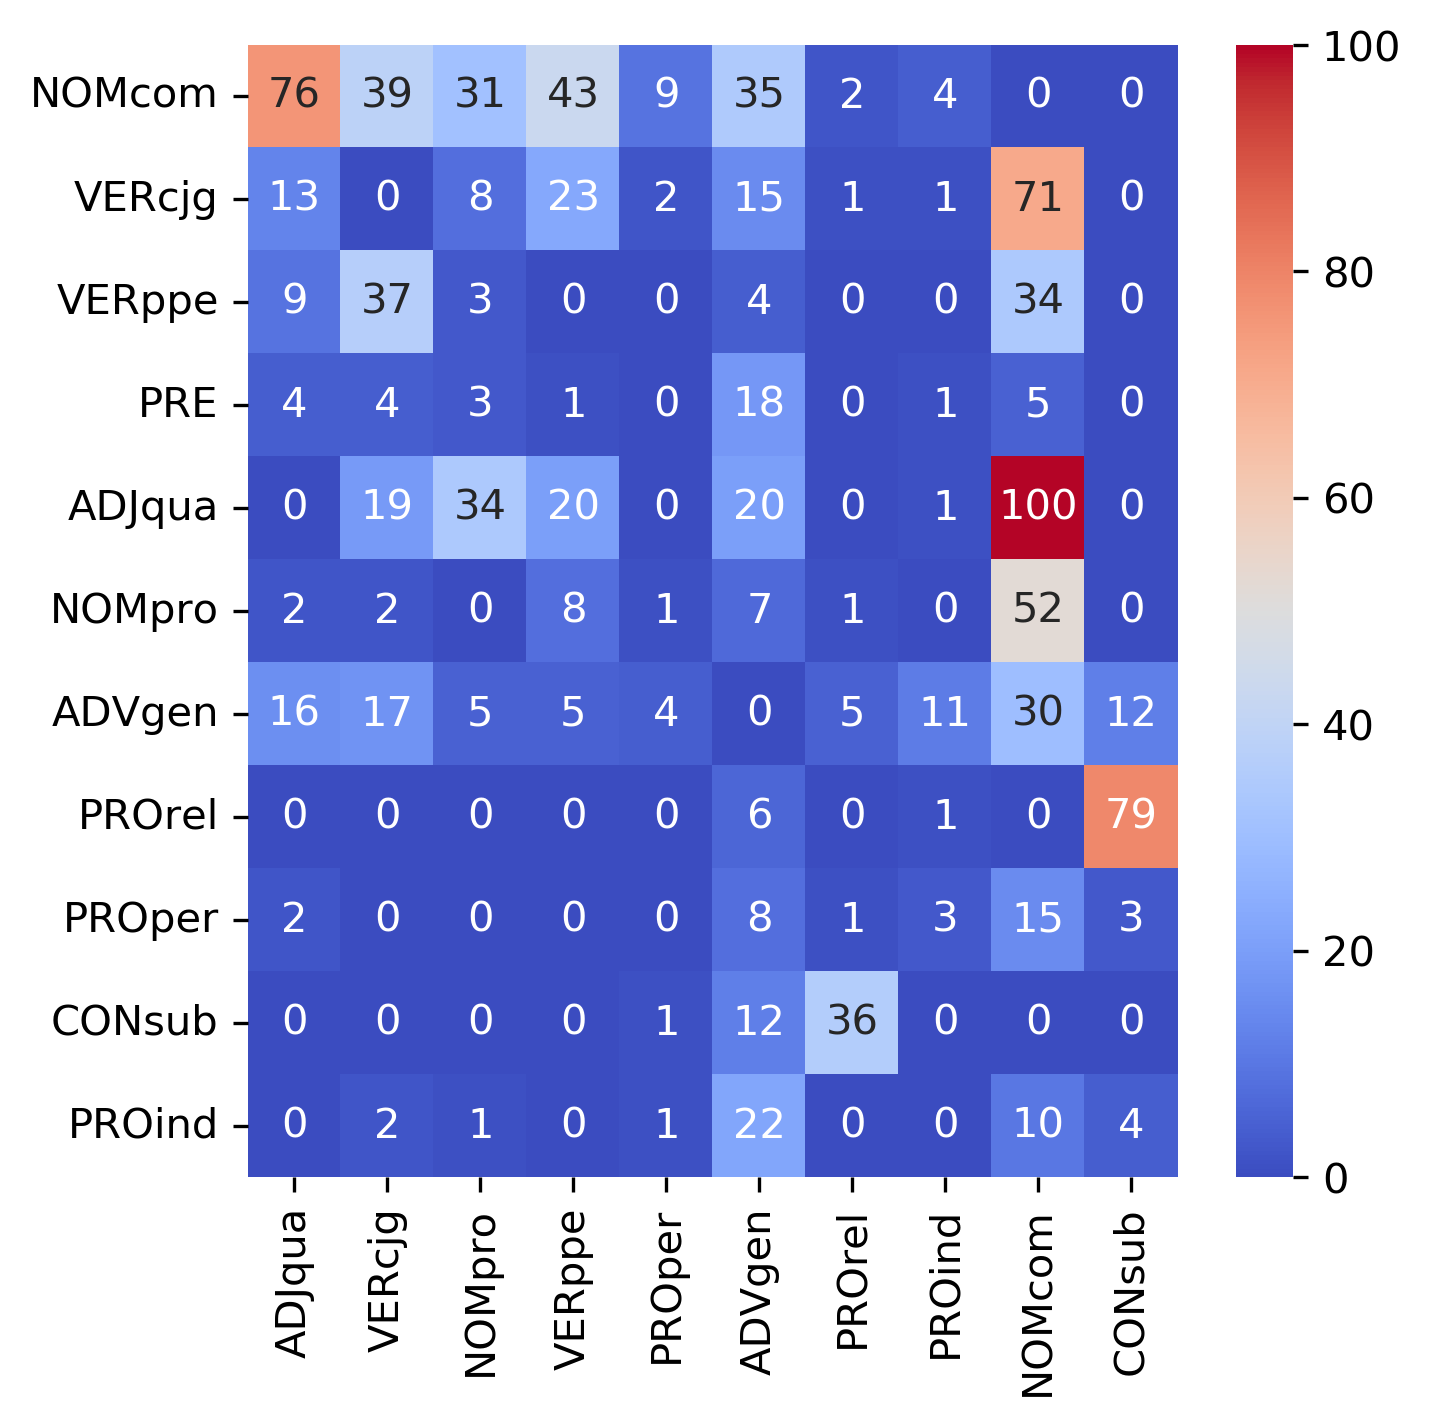

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ax = sns.heatmap(confMatDf, annot=True, fmt=".0f", cmap = "coolwarm")

# Scores by text, scripta, genre

## Get metadata and annotate texts individually

In [105]:
metadata = pd.read_csv("metadataRevuSansSpace_Genres.tsv", sep="\t")
metadata = metadata[["deaf", "lieuCompositionType", "dateCompositionType", "dateCompositionSimpl", "lieuManuscritType", "dateManuscritType","dateManuscritSimpl","genreType"]]
metadata

deaf lieuCompositionType dateCompositionType  \
0           OrsonP                 pic            1emxiiie   
1           RenN_H                 nil             2emxiie   
2         Perclo_R               champ             2emxiie   
3      AdHaleRobS*                 pic            2emxiiie   
4    RenBeaujBelW2            bourgfrc            1emxiiie   
..             ...                 ...                 ...   
288     MarieFab_B               ouest             2emxiie   
289     MarieFab_Y               ouest             2emxiie   
290  ChastVergiS_K               ouest            1emxiiie   
291    MarieLaisE2               ouest             2emxiie   
292     BenTroieM*              centre             2emxiie   

     dateCompositionSimpl lieuManuscritType dateManuscritType  \
0                  1225.0              lorr          2emxiiie   
1                  1188.0               pic          2emxiiie   
2                  1180.0               pic          1emxiiie   
3                  1285.0               pic          2emxiiie   
4                  1200.0               pic          2emxiiie   
..                    ...               ...               ...   
288                1180.0               agn          2emxiiie   
289                1180.0               nil          1emxiiie   
290                1240.0               pic             mxive   
291                1165.0               agn          2emxiiie   
292                1170.0               agn           2emxiie   

     dateManuscritSimpl genreType  
0                1290.0   chgeste  
1                1290.0  narrbref  
2                1237.0     roman  
3                1295.0   theatre  
4                1283.0  narrbref  
..                  ...       ...  
288              1290.0  narrbref  
289              1225.0  narrbref  
290              1350.0  narrbref  
291              1275.0  narrbref  
292              1190.0      hist  

[293 rows x 8 columns]

In [106]:
ScoresWithMetad = defaultdict(list)

for sample in list(GOLD.keys()):
    title = sample.rpartition('_')[0]
    myMetads = metadata.loc[(metadata[["deaf"]] == title).values,]
    
    if len(myMetads) == 0:
        print("Error for sample: "+sample)
    
    else:
        ScoresWithMetad[sample] = {"Text": title, 
                                   "dateCompositionType": myMetads[["dateCompositionType"]].values[0][0],
                                   "dateCompositionSimpl": myMetads[["dateCompositionSimpl"]].values[0][0],
                                   "lieuCompositionType": myMetads[["lieuCompositionType"]].values[0][0],
                                   "dateManuscritType": myMetads[["dateManuscritType"]].values[0][0],
                                   "dateManuscritSimpl": myMetads[["dateManuscritSimpl"]].values[0][0],
                                   "lieuManuscritType": myMetads[["lieuManuscritType"]].values[0][0],
                                  "genreType":myMetads[["genreType"]].values[0][0],
                                   "POS-acc":0.00,
                                   "lemma-acc":0.00
                                  }

ScoresWithMetad
pd.DataFrame(ScoresWithMetad, dtype=float).transpose()
#myMetads[["dateManuscritType"]].values[0]

Text dateCompositionType dateCompositionSimpl  \
ChastVergiS_A_69     ChastVergiS_A            1emxiiie               1240.0   
PsLorrA_672                PsLorrA             2emxive               1365.0   
PerNeslesTabJ_602    PerNeslesTabJ            2emxiiie               1289.0   
MerlinP_956                MerlinP            1emxiiie               1213.0   
MerlinP_1603               MerlinP            1emxiiie               1213.0   
...                            ...                 ...                  ...   
YvainL;PercL_1311     YvainL;PercL             2emxiie               1180.0   
YvainL;PercL_1877     YvainL;PercL             2emxiie               1180.0   
CharroiSch_B2*_739  CharroiSch_B2*               mxiie               1150.0   
VillehF_658                VillehF            1emxiiie               1205.0   
AlexArsL_438              AlexArsL             2emxiie               1185.0   

                   lieuCompositionType dateManuscritType dateManuscritSimpl  \
ChastVergiS_A_69                 ouest          2emxiiie             1289.0   
PsLorrA_672                       lorr           2emxive             1375.0   
PerNeslesTabJ_602                  pic          2emxiiie             1289.0   
MerlinP_956                     sudest           1emxive             1310.0   
MerlinP_1603                    sudest           1emxive             1310.0   
...                                ...               ...                ...   
YvainL;PercL_1311                champ          1emxiiie             1235.0   
YvainL;PercL_1877                champ          1emxiiie             1235.0   
CharroiSch_B2*_739                 nil           1emxive             1335.0   
VillehF_658                      champ           2emxive             1375.0   
AlexArsL_438                       pic          1emxiiie             1225.0   

                   lieuManuscritType genreType POS-acc lemma-acc  
ChastVergiS_A_69                 pic  narrbref     0.0       0.0  
PsLorrA_672                     lorr     bible     0.0       0.0  
PerNeslesTabJ_602                pic       nil     0.0       0.0  
MerlinP_956                      pic     roman     0.0       0.0  
MerlinP_1603                     pic     roman     0.0       0.0  
...                              ...       ...     ...       ...  
YvainL;PercL_1311              champ     roman     0.0       0.0  
YvainL;PercL_1877              champ     roman     0.0       0.0  
CharroiSch_B2*_739               idf  narrbref     0.0       0.0  
VillehF_658                      nil      hist     0.0       0.0  
AlexArsL_438                  centre     roman     0.0       0.0  

[275 rows x 10 columns]

In [24]:
# And now we need the scores
PLATINUM_byText = defaultdict(list)


for text in list(GOLD.keys()):
    PLATINUM_byText[text] = [
    sentence for sentence in convert_raw(GOLD[text], form_fn = lambda x: x.replace('§', ''))
]

PLATINUM_byText

100%|██████████████████████████████████████████| 7/7 [00:00<00:00, 21076.90it/s]


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13981.01it/s]


defaultdict(list,
            {'ChastVergiS_A_69': [[{'form': 'Longue',
                'lemma': 'lonc',
                'POS': 'ADJqua'},
               {'form': 'atente', 'lemma': 'atente', 'POS': 'NOMcom'},
               {'form': 'vous', 'lemma': 'vos', 'POS': 'PROper'},
               {'form': 'poroit', 'lemma': 'pöoir', 'POS': 'VERcjg'},
               {'form': 'nuire', 'lemma': 'nuire', 'POS': 'VERinf'},
               {'form': ',', 'lemma': ',', 'POS': 'PONfbl'},
               {'form': 'ce', 'lemma': 'ce1', 'POS': 'PROdem'},
               {'form': "m'", 'lemma': 'je', 'POS': 'PROper'},
               {'form': 'est', 'lemma': 'estre1', 'POS': 'VERcjg'},
               {'form': 'vis', 'lemma': 'vis2', 'POS': 'NOMcom'},
               {'form': ':', 'lemma': ':', 'POS': 'PONfbl'},
               {'form': 'si', 'lemma': 'si', 'POS': 'ADVgen'},
               {'form': 'lo', 'lemma': 'löer1', 'POS': 'VERcjg'},
               {'form': 'que', 'lemma': 'que4', 'POS': 'CONsub'},
       

In [25]:
TOKENS_byText = defaultdict(list)
for text in PLATINUM_byText:
    TOKENS_byText[text] = [[x["form"] for x in sentence]
                           for sentence in PLATINUM_byText[text]]
    
# Vérif romains
#[t for s in TOKENS for t in s if t[0] == '.']
# vérif tokens
TOKENS_byText["ChastVergiS_A_69"]

[['Longue',
  'atente',
  'vous',
  'poroit',
  'nuire',
  ',',
  'ce',
  "m'",
  'est',
  'vis',
  ':',
  'si',
  'lo',
  'que',
  'vous',
  'soiiés',
  'amis',
  'en',
  'un',
  'haut',
  'liu',
  ',',
  'se',
  'vous',
  'veés',
  'que',
  'vous',
  'i',
  'soiiés',
  'bien',
  'amés',
  '.'],
 ['»',
  'Cil',
  'respont',
  ':',
  '«',
  'Ma',
  'dame',
  ',',
  'par',
  'foi',
  ',',
  'je',
  'ne',
  'sai',
  'mie',
  'bien',
  'por',
  'quoi',
  'ce',
  'me',
  'dites',
  "n'",
  'à',
  'coi',
  'ce',
  'monte',
  ',',
  'mais',
  'je',
  'ne',
  'sui',
  'ne',
  'rois',
  'ne',
  'conte',
  'qui',
  'si',
  'hautement',
  'amer',
  'doie',
  ',',
  'ne',
  'je',
  'n’',
  'en',
  'sui',
  'mie',
  'à',
  '.II.',
  'doie',
  "d'",
  'amer',
  'dame',
  'si',
  'soveraine',
  ',',
  'se',
  'je',
  'bien',
  'i',
  'metoie',
  'paine',
  '.'],
 ['-',
  'Si',
  'estes',
  ',',
  '»',
  'fait',
  'ele',
  ',',
  '«',
  'se',
  'devient',
  ';',
  'mainte',
  'plus',
  'grans',
  'me

In [26]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 64


OUTPUT = []
TEST_NEW = True
# Lemmatise
OUTPUT_byText = defaultdict(list)

DEVICE = "cpu"
BATCH_SIZE = 64

TEST_NEW = True

#tagger = Tagger(device="cuda", batch_size=100, lower=False, tokenize=False)
tagger = Tagger(device=DEVICE, batch_size=BATCH_SIZE, lower=False, tokenize=False)
if TEST_NEW:
    for task in TASKS:
        tagger.add_model(f"modeles/{task}.tar", task)
#else:
#    tagger.add_model("../../../latin-lasla-models/lasla-plus.tar", *TASKS)

for text in TOKENS_byText:
    for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS_byText[text]], tagger.batch_size)):
        tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
        OUTPUT_byText[text].extend([
            [
                (token, dict(zip(tasks, result)))
                for token, result in sentence
            ]
            for sentence in tagged
        ])



1it [00:00,  2.77it/s]
1it [00:00,  1.89it/s]
1it [00:00,  3.63it/s]
1it [00:00,  2.99it/s]
1it [00:00,  2.96it/s]
1it [00:00,  1.74it/s]
1it [00:00,  1.46it/s]
1it [00:00,  2.21it/s]
1it [00:00,  2.08it/s]
1it [00:00,  3.20it/s]
1it [00:00,  2.51it/s]
1it [00:00,  2.64it/s]
1it [00:00,  3.39it/s]
1it [00:00,  2.60it/s]
1it [00:00,  2.90it/s]
1it [00:00,  2.92it/s]
1it [00:00,  3.02it/s]
1it [00:00,  3.27it/s]
1it [00:00,  1.47it/s]
1it [00:00,  3.00it/s]
1it [00:00,  3.20it/s]
1it [00:00,  2.39it/s]
1it [00:00,  2.25it/s]
1it [00:00,  3.13it/s]
1it [00:00,  2.29it/s]
1it [00:00,  3.27it/s]
1it [00:00,  2.54it/s]
1it [00:00,  2.56it/s]
1it [00:01,  1.22s/it]
1it [00:00,  2.50it/s]
1it [00:00,  3.07it/s]
1it [00:00,  2.53it/s]
1it [00:00,  3.25it/s]
1it [00:00,  2.87it/s]
1it [00:00,  2.68it/s]
1it [00:00,  3.12it/s]
1it [00:00,  3.05it/s]
1it [00:00,  3.39it/s]
1it [00:00,  2.62it/s]
1it [00:00,  3.88it/s]
1it [00:00,  3.04it/s]
1it [00:00,  3.13it/s]
1it [00:00,  2.71it/s]
1it [00:00,

In [27]:
OUTPUT_byText["ChastVergiS_A_69"]

[[('Longue', {'POS': 'ADJqua', 'lemma': 'lonc'}),
  ('atente', {'POS': 'NOMcom', 'lemma': 'atente'}),
  ('vous', {'POS': 'PROper', 'lemma': 'vos'}),
  ('poroit', {'POS': 'VERcjg', 'lemma': 'pöoir'}),
  ('nuire', {'POS': 'VERinf', 'lemma': 'nuire'}),
  (',', {'POS': 'PONfbl', 'lemma': ','}),
  ('ce', {'POS': 'PROdem', 'lemma': 'ce1'}),
  ("m'", {'POS': 'PROper', 'lemma': 'je'}),
  ('est', {'POS': 'VERcjg', 'lemma': 'estre1'}),
  ('vis', {'POS': 'ADJqua', 'lemma': 'vif'}),
  (':', {'POS': 'PONfbl', 'lemma': ':'}),
  ('si', {'POS': 'ADVgen', 'lemma': 'si'}),
  ('lo', {'POS': 'PROper', 'lemma': 'löer1'}),
  ('que', {'POS': 'CONsub', 'lemma': 'que4'}),
  ('vous', {'POS': 'PROper', 'lemma': 'vos'}),
  ('soiiés', {'POS': 'VERcjg', 'lemma': 'estre1'}),
  ('amis', {'POS': 'NOMcom', 'lemma': 'ami'}),
  ('en', {'POS': 'PRE', 'lemma': 'en1'}),
  ('un', {'POS': 'DETndf', 'lemma': 'un'}),
  ('haut', {'POS': 'ADJqua', 'lemma': 'haut'}),
  ('liu', {'POS': 'NOMcom', 'lemma': 'lieu'}),
  (',', {'POS': '

In [108]:
ScoresWithMetad.keys()

for text in list(ScoresWithMetad.keys()):
    #print(text)
    _, Scores_all3, *_, Score_Knowns = compile_scores(OUTPUT_byText[text], PLATINUM_byText[text], 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)
    
    
    RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT_byText[text], PLATINUM_byText[text], task_list=TASKS, 
        known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS)
    

    for task, (pred, truth) in RAW_SCORES.items():
        #(pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
        ScoresWithMetad[text][task+'-acc'] = "{0:.2f}".format(accuracy_score(truth, pred)*100)#,
            #"{0:.2f}".format(accuracy_score(pred_limited, truth_limited)*100)
        

dfFull = pd.DataFrame(ScoresWithMetad).transpose()    

dfFull["POS-acc"] = pd.to_numeric(dfFull["POS-acc"])
dfFull["lemma-acc"] = pd.to_numeric(dfFull["lemma-acc"])
time_cats = ["nil", "1emxiie", "mxiie", "2emxiie", "1emxiiie", "mxiiie","2emxiiie","1emxive","2emxive"]
cat_typeCompo = pd.CategoricalDtype(categories = time_cats, ordered=True)
cat_typeMs = pd.CategoricalDtype(categories = time_cats, ordered=True)

dfFull['dateCompositionType'] = dfFull['dateCompositionType'].astype(cat_typeCompo)
dfFull['dateManuscritType'] = dfFull['dateManuscritType'].astype(cat_typeMs)
dfFull['dateCompositionSimpl'] = dfFull['dateCompositionSimpl'].astype(float)
dfFull['dateManuscritSimpl'] = dfFull['dateManuscritSimpl'].astype(float)

dfFull
#dfFull[dfFull.index.duplicated()]

Text dateCompositionType  dateCompositionSimpl  \
ChastVergiS_A_69     ChastVergiS_A            1emxiiie                1240.0   
PsLorrA_672                PsLorrA             2emxive                1365.0   
PerNeslesTabJ_602    PerNeslesTabJ            2emxiiie                1289.0   
MerlinP_956                MerlinP            1emxiiie                1213.0   
MerlinP_1603               MerlinP            1emxiiie                1213.0   
...                            ...                 ...                   ...   
YvainL;PercL_1311     YvainL;PercL             2emxiie                1180.0   
YvainL;PercL_1877     YvainL;PercL             2emxiie                1180.0   
CharroiSch_B2*_739  CharroiSch_B2*               mxiie                1150.0   
VillehF_658                VillehF            1emxiiie                1205.0   
AlexArsL_438              AlexArsL             2emxiie                1185.0   

                   lieuCompositionType dateManuscritType  dateManuscritSimpl  \
ChastVergiS_A_69                 ouest          2emxiiie              1289.0   
PsLorrA_672                       lorr           2emxive              1375.0   
PerNeslesTabJ_602                  pic          2emxiiie              1289.0   
MerlinP_956                     sudest           1emxive              1310.0   
MerlinP_1603                    sudest           1emxive              1310.0   
...                                ...               ...                 ...   
YvainL;PercL_1311                champ          1emxiiie              1235.0   
YvainL;PercL_1877                champ          1emxiiie              1235.0   
CharroiSch_B2*_739                 nil           1emxive              1335.0   
VillehF_658                      champ           2emxive              1375.0   
AlexArsL_438                       pic          1emxiiie              1225.0   

                   lieuManuscritType genreType  POS-acc  lemma-acc  
ChastVergiS_A_69                 pic  narrbref    96.58      95.73  
PsLorrA_672                     lorr     bible    90.74      88.27  
PerNeslesTabJ_602                pic       nil    83.67      79.59  
MerlinP_956                      pic     roman    94.55      93.64  
MerlinP_1603                     pic     roman    96.69      95.87  
...                              ...       ...      ...        ...  
YvainL;PercL_1311              champ     roman    94.74      95.79  
YvainL;PercL_1877              champ     roman    98.26      98.26  
CharroiSch_B2*_739               idf  narrbref    93.50      82.93  
VillehF_658                      nil      hist    96.55      94.25  
AlexArsL_438                  centre     roman    88.35      93.20  

[275 rows x 10 columns]

## Scripta vs genre heatmap

In [29]:
dfFull.loc["ChastVergiS_A_69"][["POS-acc"]]

POS-acc    96.58
Name: ChastVergiS_A_69, dtype: object

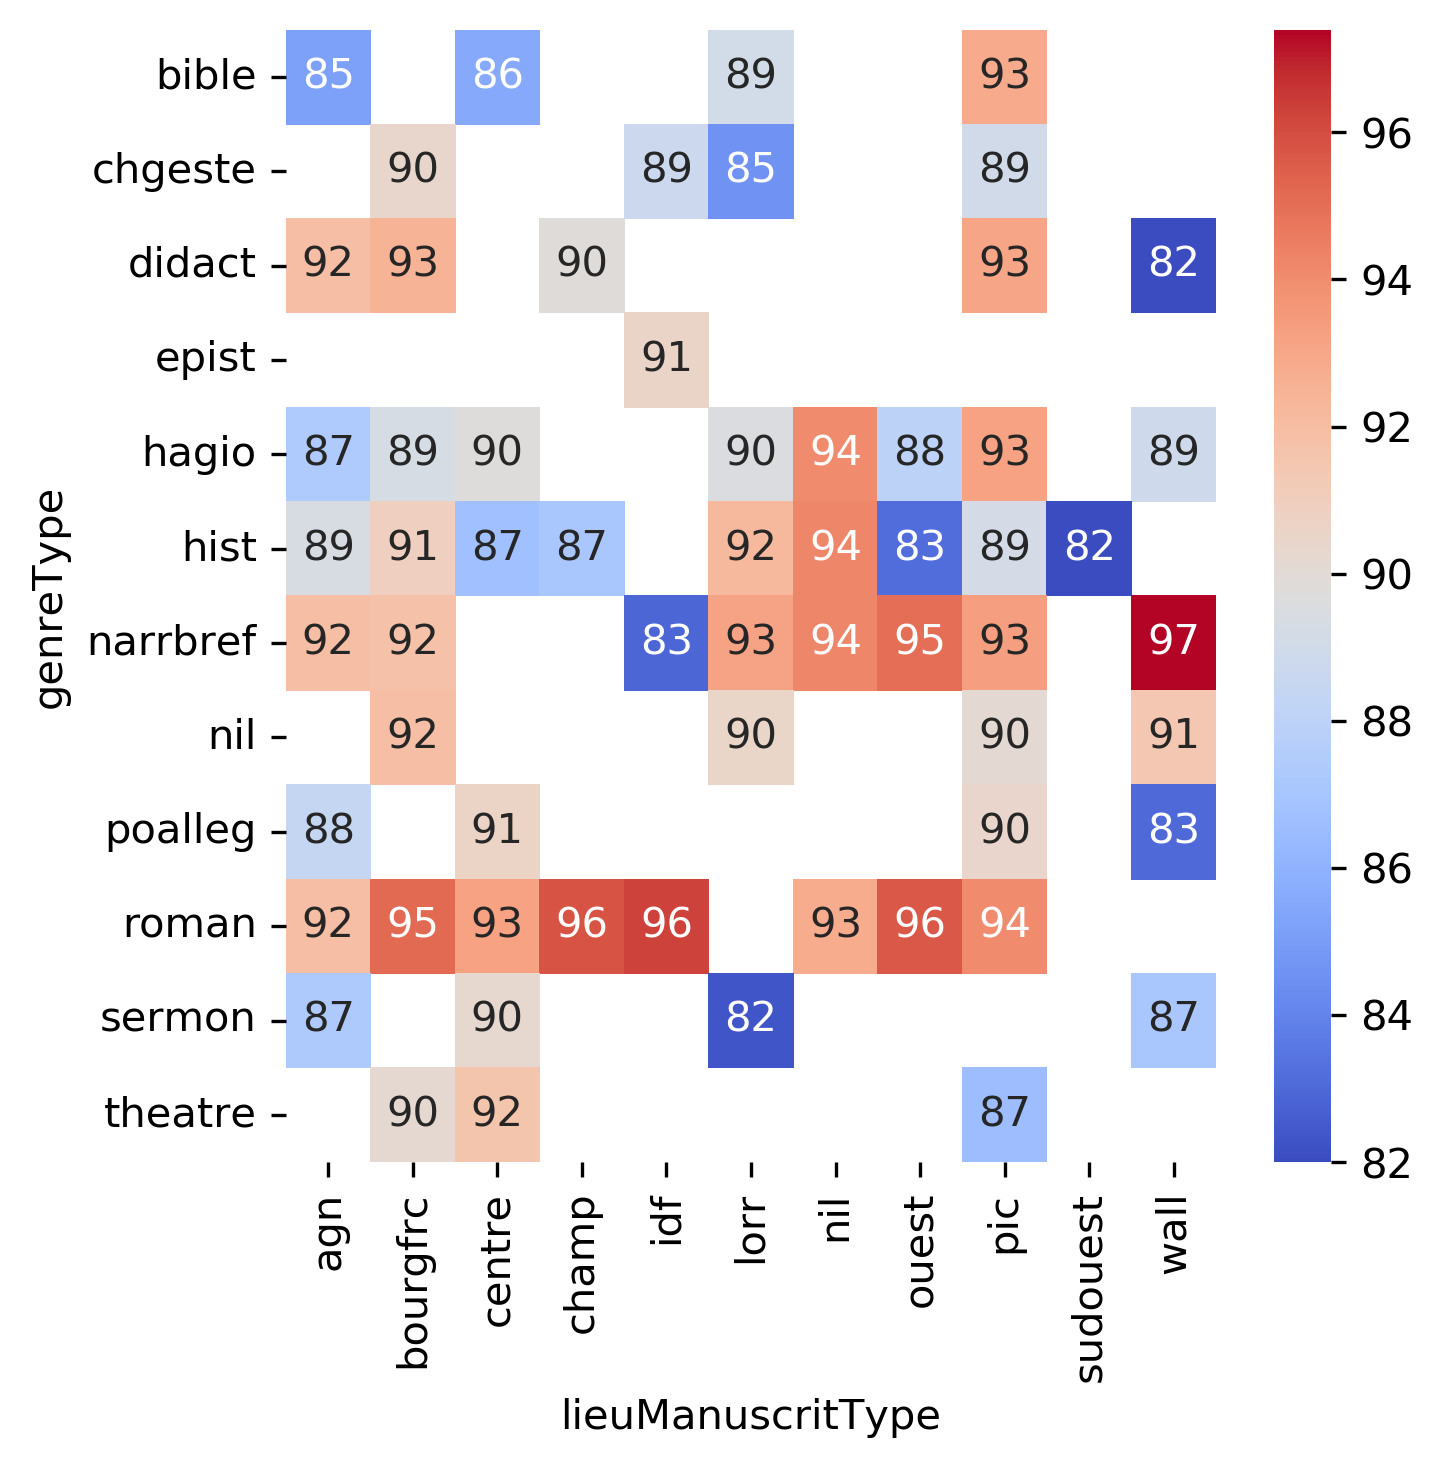

In [30]:
#dfFull[0:3][:].pivot(index="genreType", columns="lieuManuscritType", values="lemma-acc")
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
df = pd.pivot_table(dfFull, index="genreType", columns="lieuManuscritType", values="lemma-acc", aggfunc='median')
# on restreint aux classes d'effectif au moins 5, et on trace
ax = sns.heatmap(df.loc[(df.sum(axis=1) > 4), (df.sum(axis=0) > 4)], annot=True, cmap = "coolwarm")

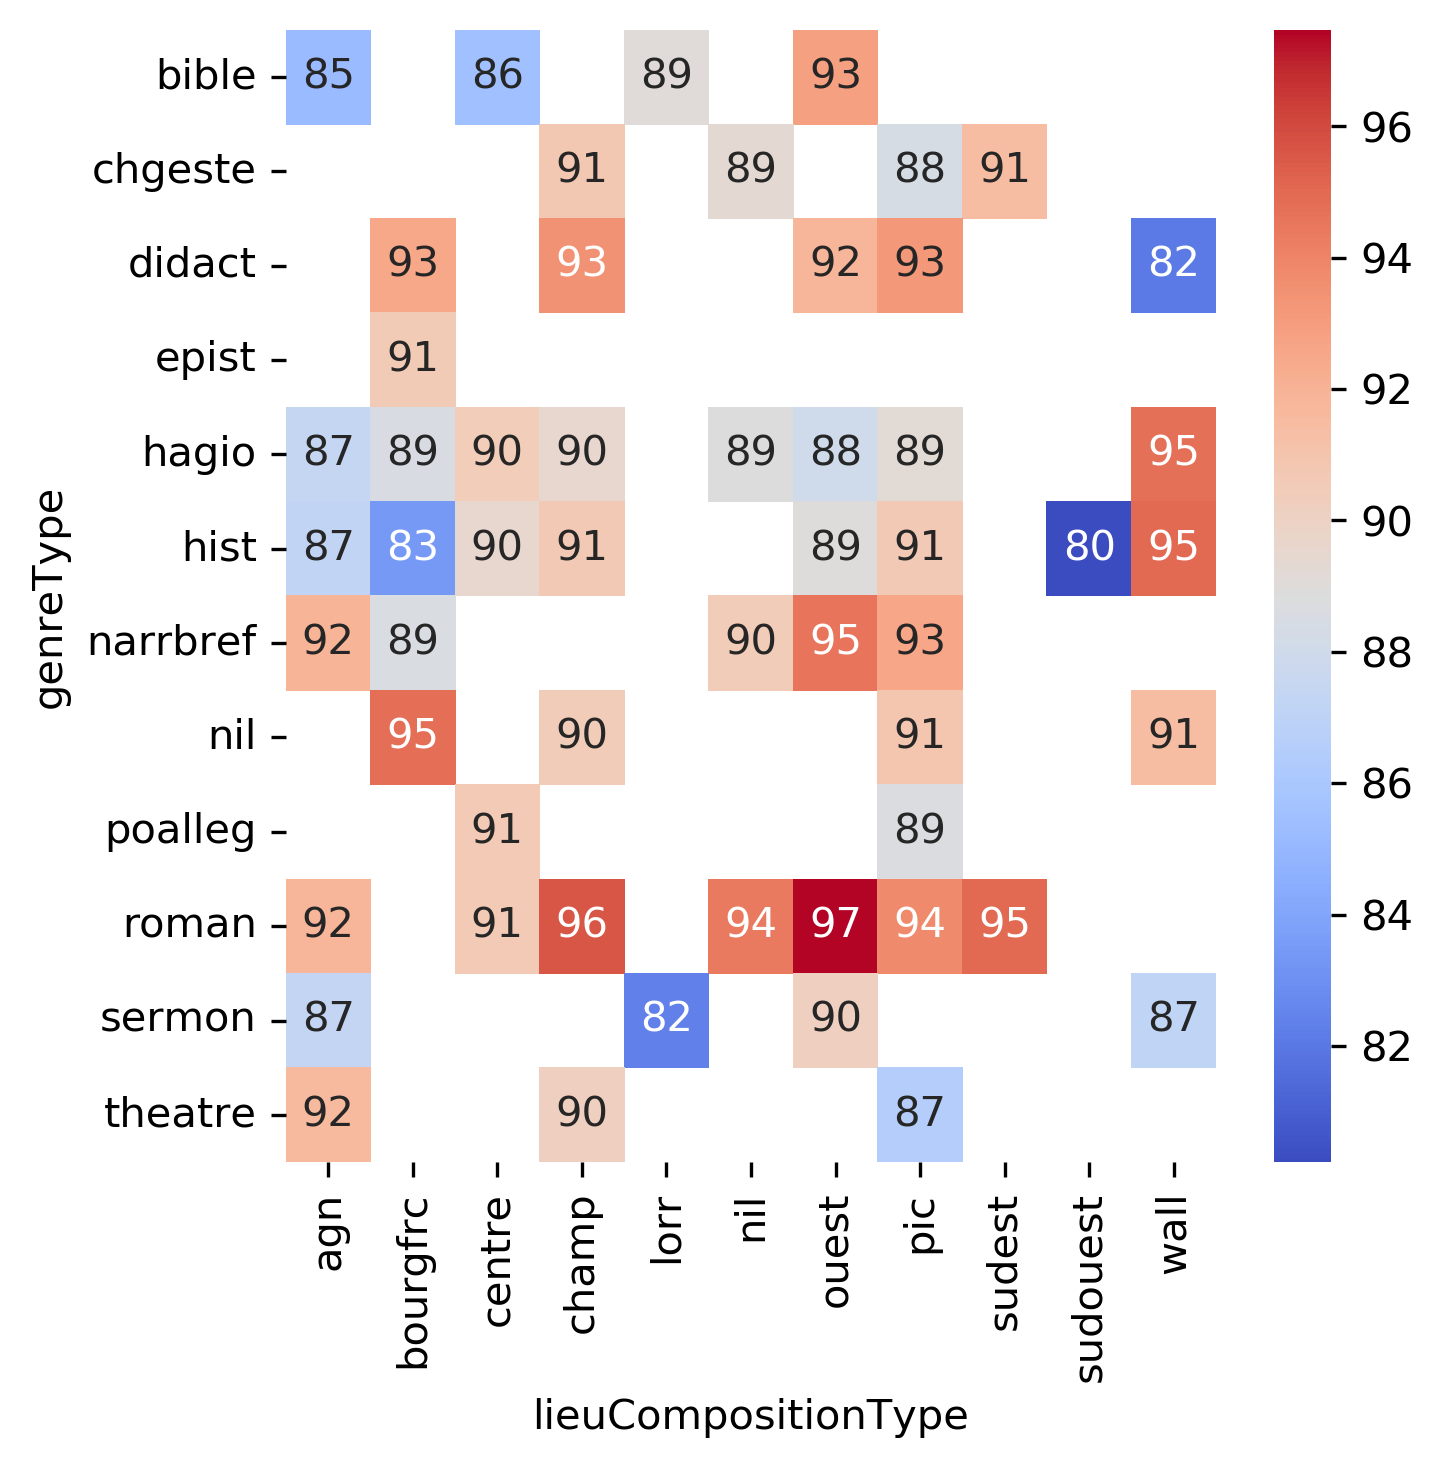

In [31]:
#dfFull[0:3][:].pivot(index="genreType", columns="lieuManuscritType", values="lemma-acc")
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
df = pd.pivot_table(dfFull, index="genreType", columns="lieuCompositionType", values="lemma-acc", aggfunc='median')
# on restreint aux classes d'effectif au moins 5, et on trace
ax = sns.heatmap(df.loc[(df.sum(axis=1) > 4), (df.sum(axis=0) > 4)], annot=True, cmap = "coolwarm")

## Lemma and POS per scripta

In [95]:
def create_boxplots(df, myColumns, scores = ['lemma-acc', 'POS-acc']):
    '''Function to create a group of boxplots
    myColumns is a list of four columns from the df to use
    '''
    
    if(len(myColumns) == 1):
        fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=300, squeeze=False)#, sharey='row', sharex='col')
                
        ##boxplot
        xlabels = axs[0][0].get_xticklabels()
        axs[0][0].set_xticklabels(xlabels, rotation=70)
        sns.boxplot(x = myColumns[0], y = scores[0], data = df, ax=axs[0][0]) 
        xlabels = axs[0][1].get_xticklabels()
        axs[0][1].set_xticklabels(xlabels, rotation=70)
        sns.boxplot(x = myColumns[0], y = scores[1], data = df, ax=axs[0][1]) 

        
    if(len(myColumns) == 2):
        fig, axs = plt.subplots(2, 2, figsize=(14, 14), dpi=300)#, sharey='row', sharex='col')
        
        ##boxplot
        xlabels = axs[0][0].get_xticklabels()
        axs[0][0].set_xticklabels(xlabels, rotation=70)
        sns.boxplot(x = myColumns[0], y = scores[0], data = df, ax=axs[0][0]) 
        xlabels = axs[0][1].get_xticklabels()
        axs[0][1].set_xticklabels(xlabels, rotation=70)
        sns.boxplot(x = myColumns[1], y = scores[0], data = df, ax=axs[0][1]) 
        xlabels = axs[1][0].get_xticklabels()
        axs[1][0].set_xticklabels(xlabels, rotation=70)
        sns.boxplot(x = myColumns[0], y = scores[1], data = df, ax=axs[1][0]) 
        xlabels = axs[1][1].get_xticklabels()
        axs[1][1].set_xticklabels(xlabels, rotation=70)
        sns.boxplot(x = myColumns[1], y = scores[1], data = df, ax=axs[1][1]) 

        # set labels
        plt.setp(axs[0,0], ylabel=scores[0])
        plt.setp(axs[1,0], ylabel=scores[1])
        plt.setp(axs[:,1], ylabel='')
        #
        plt.setp(axs[1,0], xlabel=myColumns[0])
        plt.setp(axs[1,1], xlabel=myColumns[1])
        plt.setp(axs[0,:], xlabel='')
        
    
#fig.show()



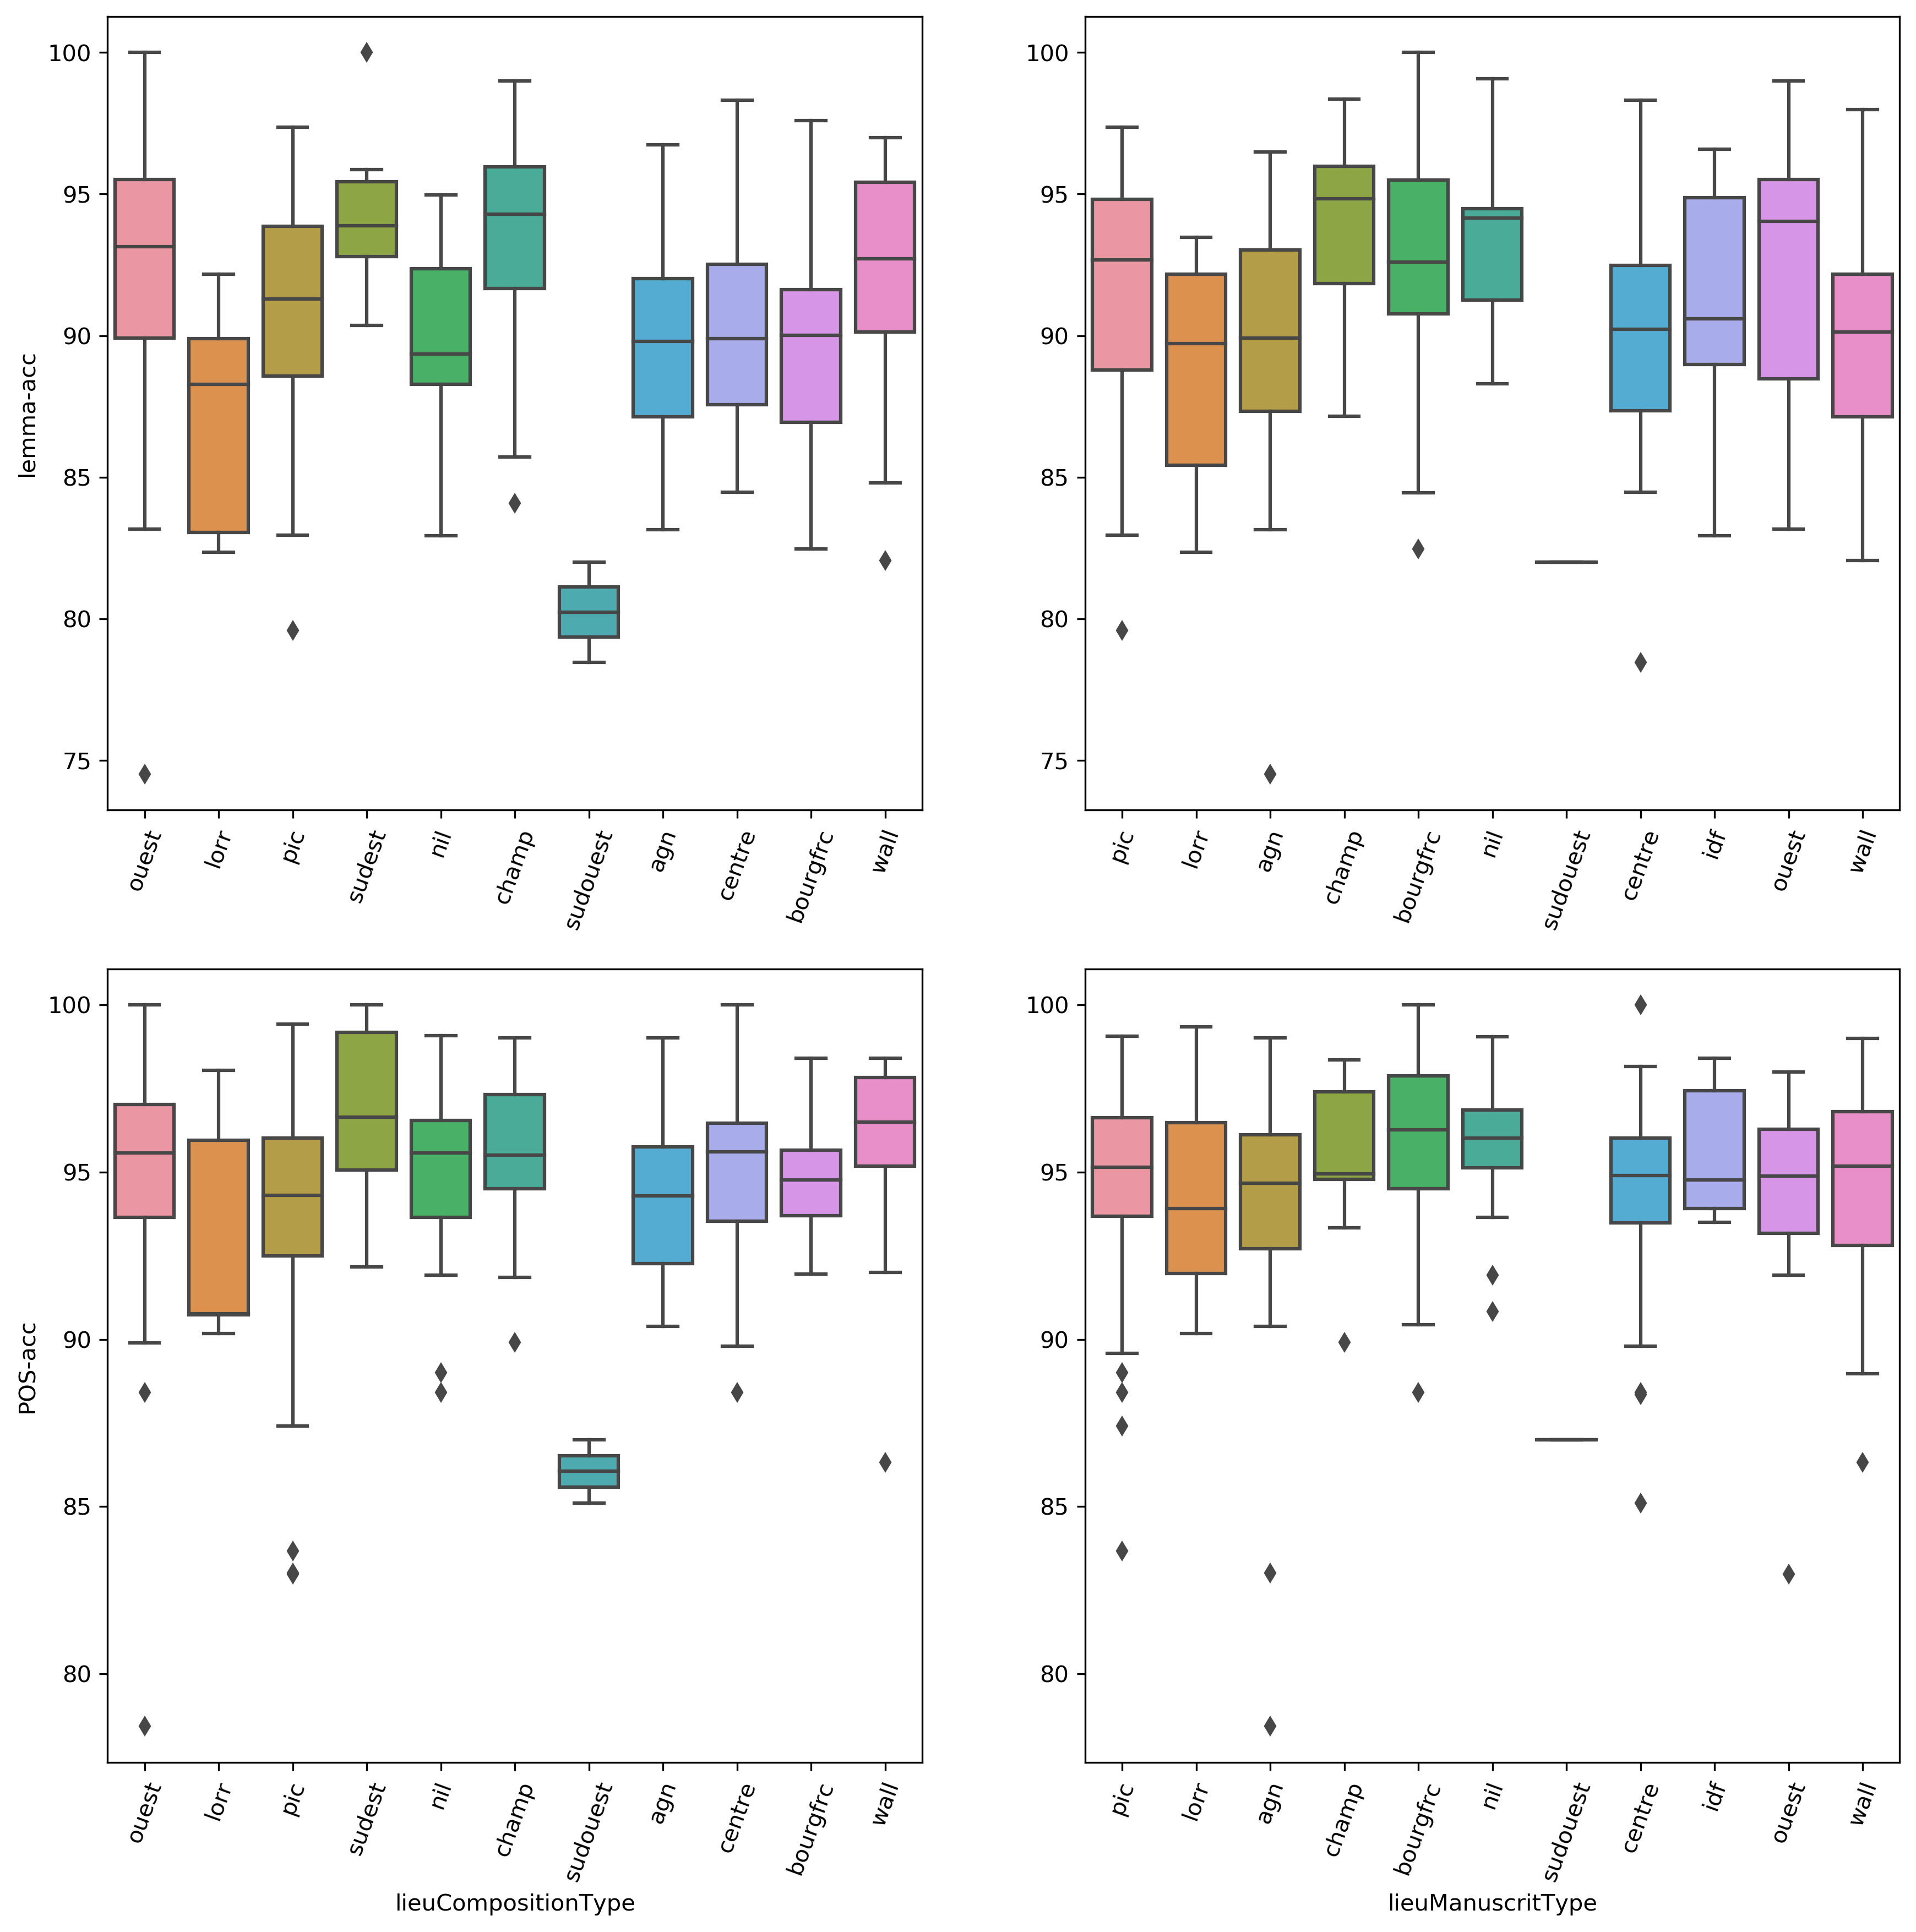

In [91]:
##boxplot
create_boxplots(dfFull, ['lieuCompositionType', 'lieuManuscritType'], scores = ['lemma-acc', 'POS-acc'])
#plt.savefig('visualisationsv2/boxplots/tidyLex/LemmaAccLieuCompoBP.png', dpi=300, transparent=False,bbox_inches='tight')

## Lemma and POS per genre

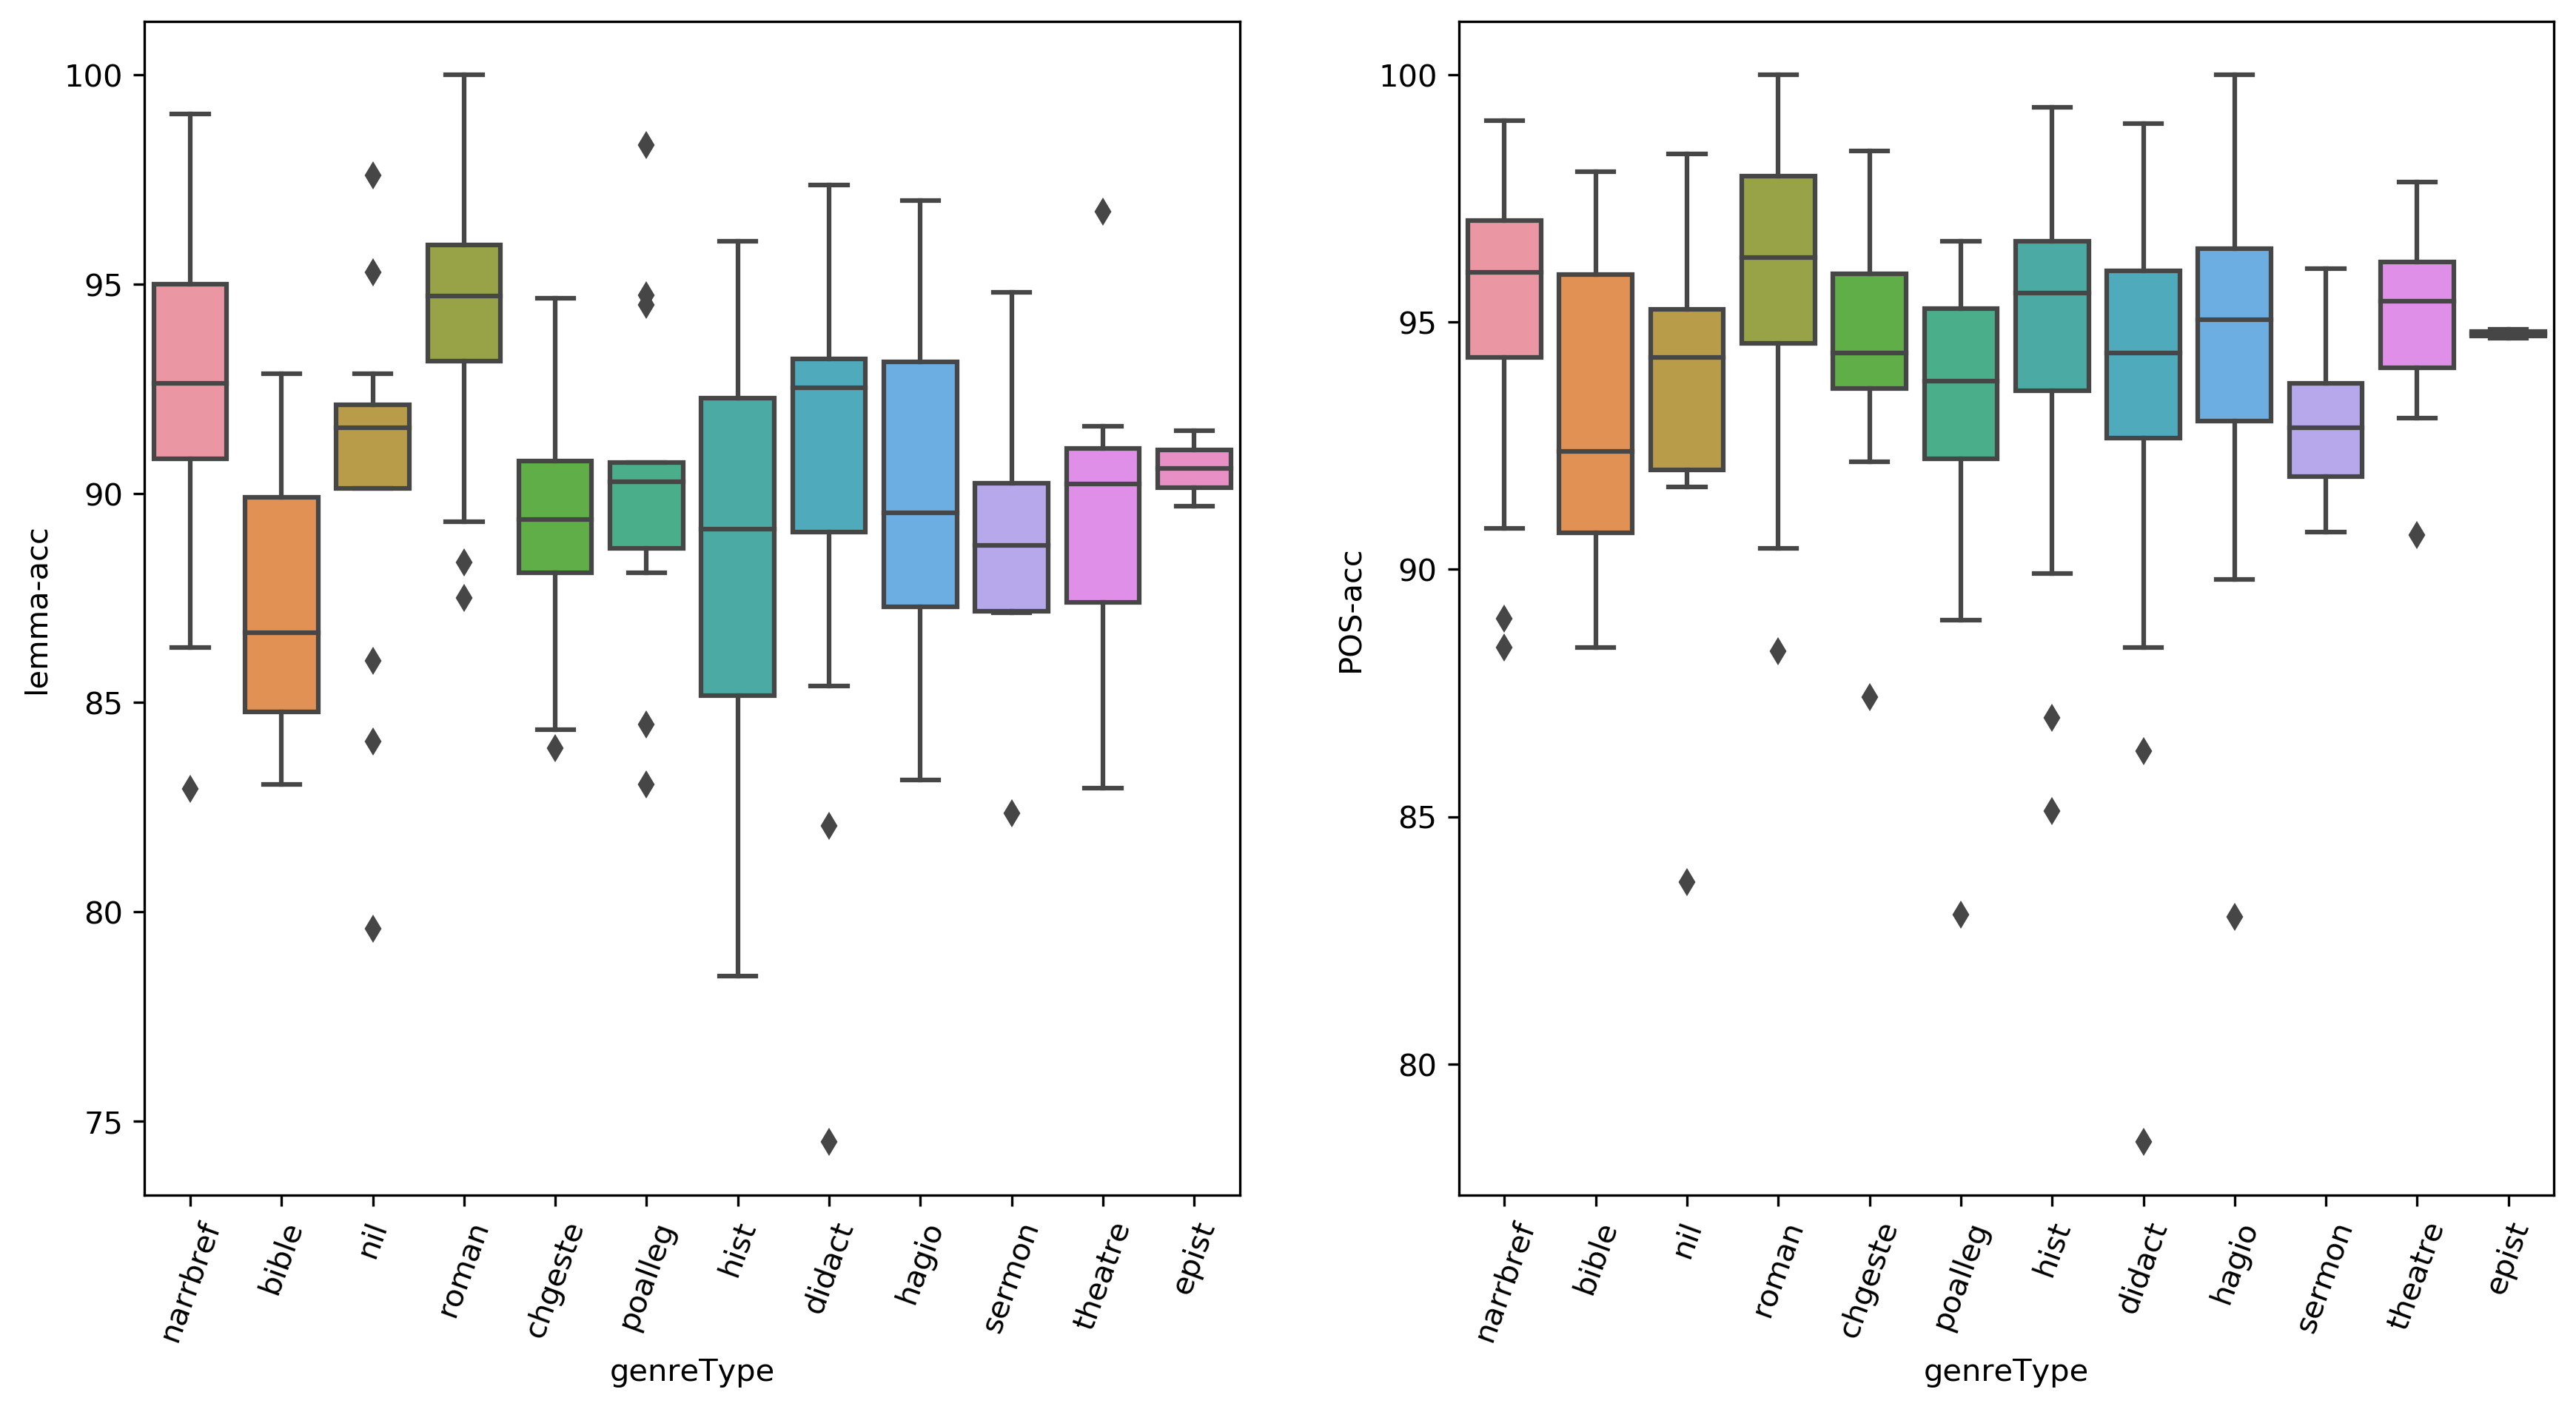

In [96]:
##boxplot
create_boxplots(dfFull, ['genreType'], scores = ['lemma-acc', 'POS-acc'])
#plt.savefig('visualisationsv2/boxplots/tidyLex/LemmaAccLieuCompoBP.png', dpi=300, transparent=False,bbox_inches='tight')

## Lemma and POS per date

(array([  4.,  49., 139.,  58.,  23.]),
 array([1137. , 1189.6, 1242.2, 1294.8, 1347.4, 1400. ]),
 <a list of 5 Patch objects>)

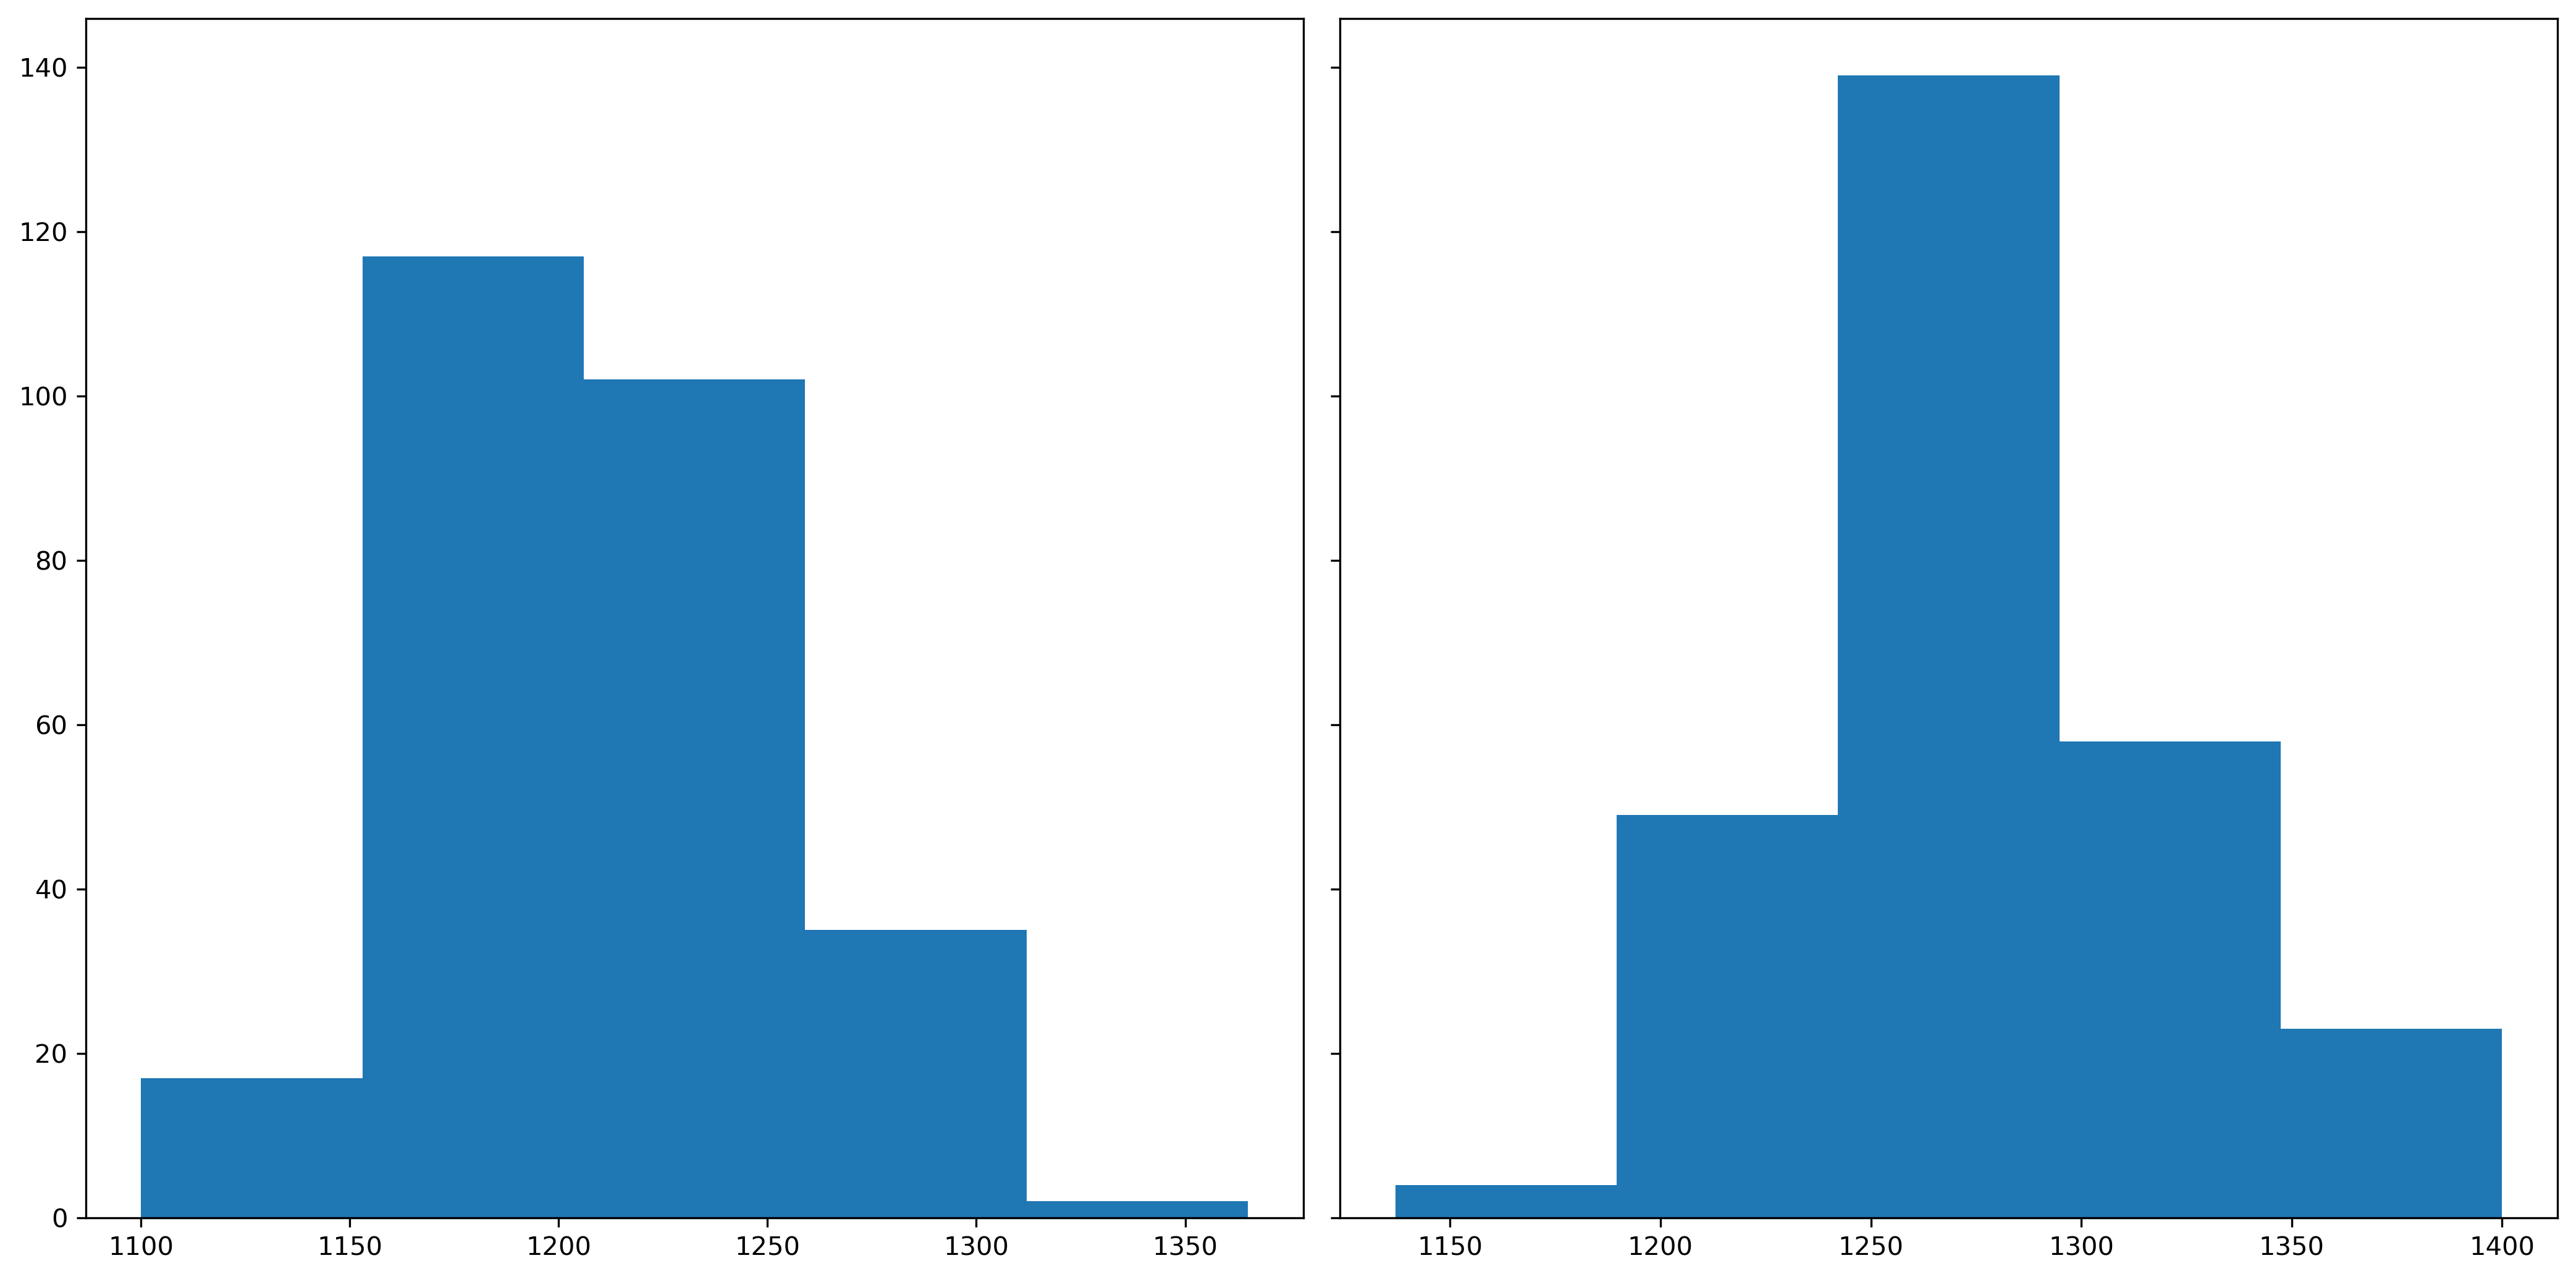

In [ ]:
##boxplot
n_bins = 5
fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=300, sharey=True, tight_layout=True)#, sharey='row', sharex='col')

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(dfFull["dateCompositionSimpl"], bins=n_bins)
axs[1].hist(dfFull["dateManuscritSimpl"], bins=n_bins)

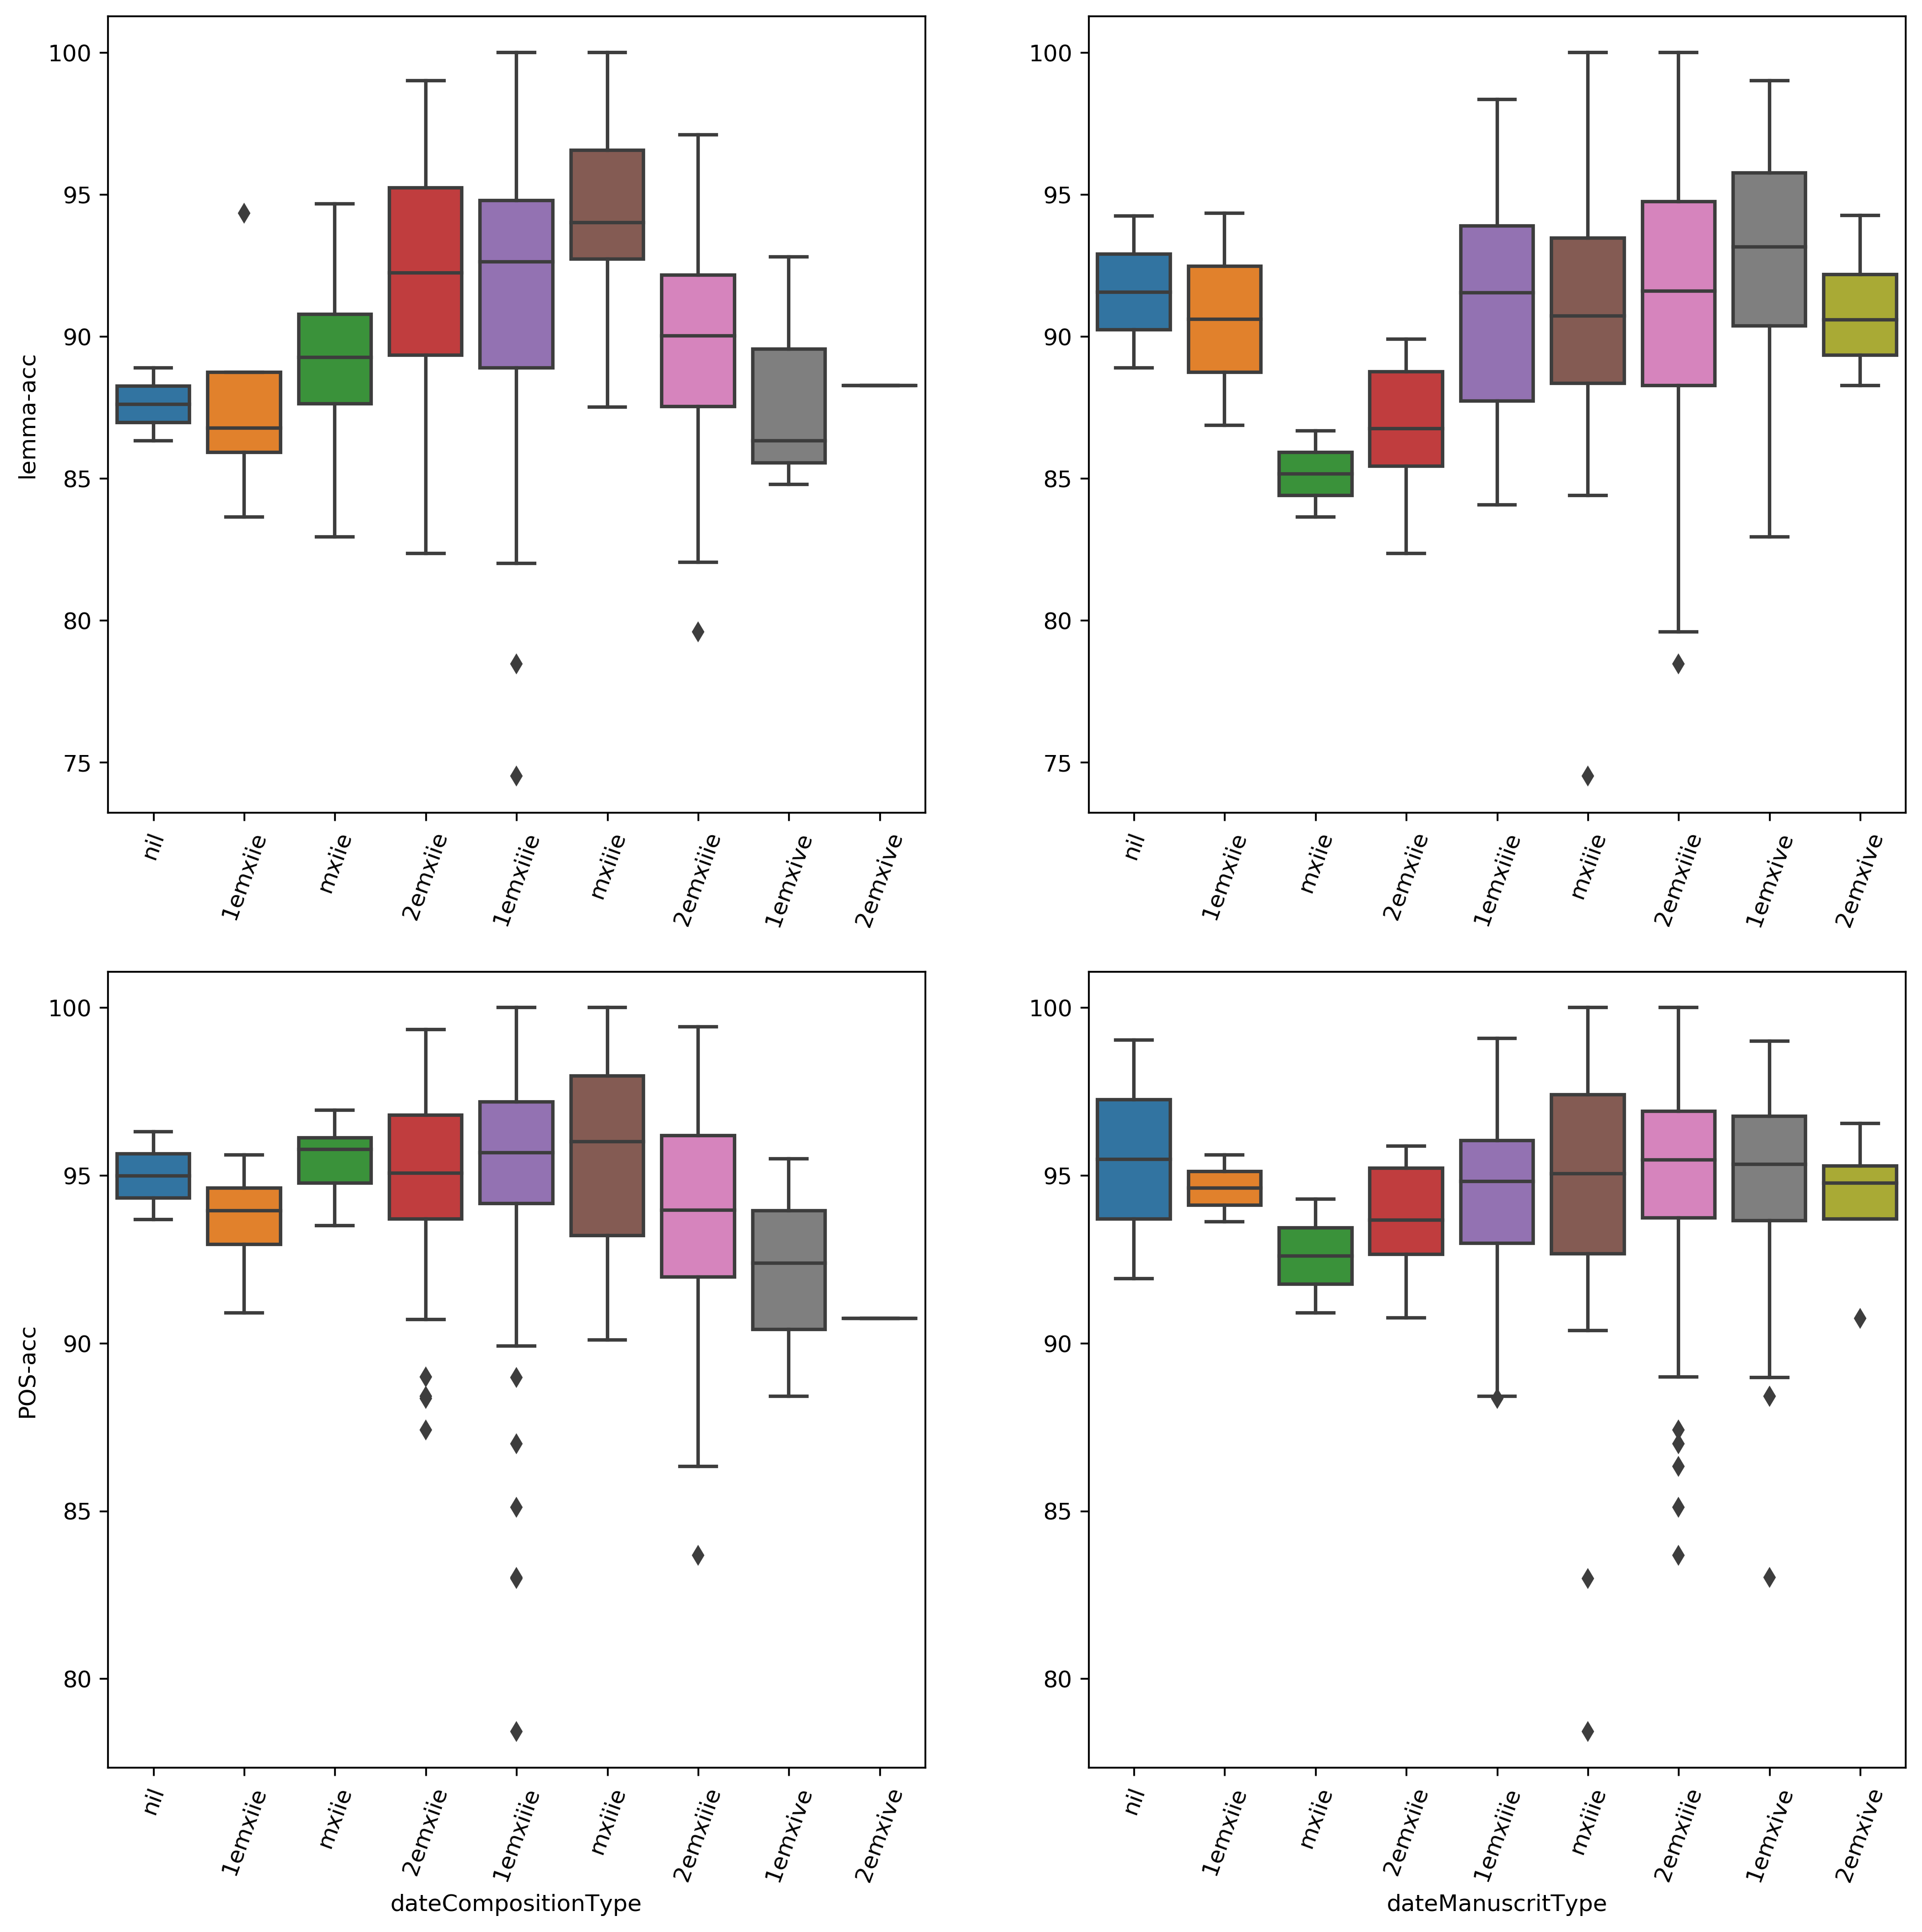

In [110]:


create_boxplots(dfFull, ['dateCompositionType', 'dateManuscritType'], scores = ['lemma-acc', 'POS-acc'])
#plt.savefig('visualisationsv2/boxplots/tidyLex/LemmaAccLieuCompoBP.png', dpi=300, transparent=False,bbox_inches='tight')